## From Wang et al. 2022 (The high latitude spectroscopic survey on the Nancy Grace Roman Space Telescope), we make a file for the galaxy number density distribution. --08-18-2023
Take reference from /home/zjding/csst_bao/fisher_pkmu/parameter_preparation/Sigma_nl_linear_order.ipynb

Derive the relation between the angular number density $\frac{dN}{dzd\Omega}$ and volume number density $dN/dV$:
\begin{align}
f_1 = \frac{dN}{dzd\Omega}\\
f_2 = dN/dV = \frac{dN}{s^2d\Omega ds}=f_1 \frac{dz}{s^2ds}.
\end{align}
We have 
\begin{align}
s = \int\frac{cdz}{H_0\sqrt{(1+z)^3 \Omega_m + \Omega_{\Lambda}}},
\end{align}
hence,
\begin{align}
f_2 = \frac{f_1}{c s^2} H_0\sqrt{(1+z)^3 \Omega_m + \Omega_{\Lambda}}.
\end{align}

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("/home/zjding/DESI_mockchallenge/bao_fit/pymodule_barn")
from mcmc_funs import growth_factor
from scipy import interpolate, integrate

In [3]:
def Sigma2_dd_integrand(k, splPlin, R_bao, Sigma2_sm):
    Pk_lin_0 = splPlin(k)
    Sm_kernel = np.exp(-0.5*k*k * Sigma2_sm)        # 1/2 factor consistent with the convention of the smoothing factor in MC
    return Pk_lin_0*(1.0-Sm_kernel)**2.0

def cal_growth_rate(a_z, omega_m):
    a_z_p = a_z+0.01
    a_z_m = a_z-0.01
    D_p = growth_factor(1./a_z_p-1, omega_m)
    D_m = growth_factor(1./a_z_m-1, omega_m)
    f = (np.log(D_p)-np.log(D_m))/(np.log(a_z_p) - np.log(a_z_m))
    return f

def comoving_dis_fun(z, Omega_m, speed_c):
    res = speed_c/(100.0 * (Omega_m*(1+z)**3 + (1-Omega_m))**0.5) 
    return res

def volden_from_surfaceden(f1, z, Omega_m, speed_c):
    s = integrate.quad(comoving_dis_fun, 0., z, args=(Omega_m, speed_c))[0]
    f2 = f1 / (s**2.0 * comoving_dis_fun(z, Omega_m, speed_c))
    return f2

In [4]:
Omega_m = 0.3075
speed_c = 299792.458    # speed of light, km/s
skyarea_total = 4*np.pi * (180./np.pi)**2.0    # unit: deg^2
print(skyarea_total)
deg2_per_str = 1/(180./np.pi)**2.0    # deg^2 to steradian 

41252.96124941928


## below is based on Table 1 and Table 2 with dust model Av=1.92 of Wang et al. 2022

In [5]:
zmin_array = np.arange(1.0, 2.91, 0.1)
zmax_array = np.arange(1.1, 3.01, 0.1)
print(zmin_array, zmax_array)
dN_dOmegadz_Halpha = np.array([12120, 10620, 7537, 8217, 6410, 4790, 3887, 2997, 1640, 1367])  # dN/dz per square degree for Halpha ELGs
dN_dOmegadz_OIII = np.array([555, 345, 395, 522, 267, 275, 160, 140, 195, 122])    # dN/dz per square degree for OIII
dN_dOmegadz = np.append(dN_dOmegadz_Halpha, dN_dOmegadz_OIII)
dN_dstrdz = dN_dOmegadz /deg2_per_str

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9] [1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8
 2.9 3. ]


In [6]:
zmid_array = (zmin_array + zmax_array)/2.0
spl_f1 = interpolate.InterpolatedUnivariateSpline(zmid_array, dN_dstrdz)

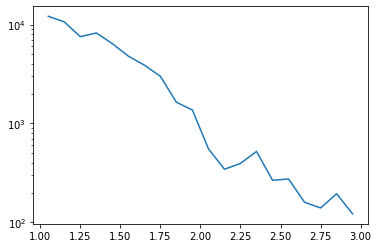

In [7]:
plt.plot(zmid_array, spl_f1(zmid_array) * deg2_per_str)
plt.yscale("log")

In [8]:
zmin_sel = np.array([1.0, 1.2, 1.4, 1.6, 2.0, 2.4])
zmax_sel = np.array([1.2, 1.4, 1.6, 2.0, 2.4, 3.0])
zmid_sel = (zmin_sel+zmax_sel)/2.0

In [9]:
nz_list = []
for z in zmid_sel:
    nz = volden_from_surfaceden(spl_f1(z), z, Omega_m, speed_c)
    nz_list.append(nz)
n_z = np.array(nz_list)

In [10]:
## calculate growth rate
a_array = 1./(1+zmid_sel)
f_array = cal_growth_rate(a_array, Omega_m)
bias_Halpha = 0.9*zmid_sel[zmid_sel<2.0] + 0.5    # for 1.0<z<2.0, it is different when z>2.0, see Fig. 6
bias_OIII = zmid_sel[zmid_sel>2.0] + 0.5
bias_array = np.append(bias_Halpha, bias_OIII)
print(f_array, bias_array)

[0.88775796 0.911352   0.92907736 0.94806607 0.96436808 0.97654152] [1.49 1.67 1.85 2.12 2.7  3.2 ]


In [11]:
# input (theoretical) linear power spectrum
ifile_pklin = "/home/zjding/DESI_mockchallenge/bao_fit/stage2_3Gpc_postrec/data/plin_model/Pk_Planck15_Table4.txt"
kwig, Plin_wig = np.loadtxt(ifile_pklin, dtype='f8', comments='#', unpack=True) 
splPlin = interpolate.InterpolatedUnivariateSpline(kwig, Plin_wig)

In [12]:
q_max = 100.0
Sigma_sm = 1.e4    # a very large number for pre-recon
G_0 = growth_factor(0.0, Omega_m)        # G_0 at z=0, normalization factor
Sigma_z_list = []
Sigma_xy_list = []
for z, f in zip(zmid_sel, f_array):
    print("z, f:", z, f)
    norm_gf = growth_factor(z, Omega_m)/G_0
    const = 1.0/(6.0*np.pi**2.0) * norm_gf**2.0
    

    Sigma2_sm = Sigma_sm **2.0
    Sigma2_dd = const * integrate.quad(Sigma2_dd_integrand, kwig[0], 100.0, args=(splPlin, q_max, Sigma2_sm), epsabs=1.e-4, epsrel=1.e-4)[0]
    Sigma_xy = (2.0*Sigma2_dd)**0.5         # There is a factor of 2 due to different expression between Eq. 84 of Blanchard paper and the usual one in the BOSS analysis.
    Sigma_z = (1.0+f)*Sigma_xy
    print("Sigma_z, Sigma_xy:", Sigma_z, Sigma_xy)
    Sigma_z_list.append(Sigma_z)
    Sigma_xy_list.append(Sigma_xy)

z, f: 1.1 0.8877579625451413
Sigma_z, Sigma_xy: 9.202704940001974 4.8749390136829645
z, f: 1.2999999999999998 0.911351999890697
Sigma_z, Sigma_xy: 8.585288288440985 4.491735844016144
z, f: 1.5 0.9290773608253158
Sigma_z, Sigma_xy: 8.024737620832687 4.159883778533106
z, f: 1.8 0.948066071462095
Sigma_z, Sigma_xy: 7.285655769124769 3.7399428468340488
z, f: 2.2 0.9643680826720901
Sigma_z, Sigma_xy: 6.465581057573697 3.2914305188560684
z, f: 2.7 0.9765415178037479
Sigma_z, Sigma_xy: 5.650364476517596 2.8587127695632972


In [13]:
output = np.array([zmin_sel, zmax_sel, n_z, bias_array, f_array, np.array(Sigma_z_list), np.array(Sigma_xy_list)]).T
header = "z_low   z_up   n(z) [h/Mpc]^3   bias    growth_rate(f)     Sigma_z     Sigma_xy"
ofile = "./nz_bias_f_Sigmanl_Wang2022.txt"
np.savetxt(ofile, output, fmt="%.7e", header=header, comments='#')